#### Requirements 

In [1]:
# !pip install tensorflow 
# !pip install numpy 
# !pip install pandas
# !pip install matplotlib
# !pip install scikit-learn
# !pip install seaborn


#### GPU usage for tf

In [2]:
!nvidia-smi # veriying if NVIDEA drive and CUDA runtime loads 

ERROR: Option # is not recognized. Please run 'nvidia-smi -h'.



In [3]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam

# 1) Ver todas as GPUs
gpus = tf.config.list_physical_devices("GPU")
print("GPUs detectadas:", gpus)

if gpus:
    # 2) (Opcional) limitar a visão só à primeira GPU
    tf.config.set_visible_devices(gpus[0], "GPU")

    # 3) (Recomendado) liberar memória sob demanda
    tf.config.experimental.set_memory_growth(gpus[0], True)

GPUs detectadas: []


#### Other libs

In [4]:
# LIBS

import os
import sys
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')
from sklearn.preprocessing import MinMaxScaler

import seaborn as sns
from pandas.plotting import register_matplotlib_converters
# import statsmodels.api as sm
# from pmdarima import auto_arima
#bibliotecas usadas no gridserach
from sklearn.model_selection import TimeSeriesSplit
import keras

register_matplotlib_converters()
sns.set_style("darkgrid")

plt.rc("figure", figsize=(16, 6))
plt.rc("font", size=13)

from matplotlib.pyplot import figure

figure(figsize = (16, 6), dpi = 100)

<Figure size 1600x600 with 0 Axes>

<Figure size 1600x600 with 0 Axes>

#### Model improvement

In [5]:
#gridsearch
def grid_search_cv(modelo, units, X_train, learning_rates, y_train, epochs_list, batch_sizes, patiences, model_name):
    best_loss = float('inf')
    best_params = {}
    for lr in learning_rates:
        for epochs in epochs_list:
            for batch_size in batch_sizes:
                for patience in patiences:
                    model = modelo(units, X_train, lr)
                    histories = fit_model_with_cross_validation(model, X_train, y_train, model_name, patience, epochs, batch_size)
                    mean_history = calculate_mean_history(histories)
                    val_loss = min(mean_history['val_loss'])
                    print("Val Loss: ", val_loss, "learning rate: ", lr, "epochs: ",  epochs, "batch_size: " , batch_size, "patience: ", patience)
                    if val_loss < best_loss:
                        best_loss = val_loss
                        best_params = {'learning_rate': lr, 'epochs': epochs, 'batch_size': batch_size, 'patience': patience} 
    print('O modelo '+model_name+ ' tem como melhores parametros os seguintes: learning_rate '+ str(best_params['learning_rate'])+' epochs: '+ str(best_params['epochs'])+' batch_size: '+ str(best_params['batch_size'])+ ' patience: '+ str(best_params['patience']))
    return best_params

#validação cruzada
def fit_model_with_cross_validation(model, xtrain, ytrain, model_name, patience, epochs, batch_size):
    tscv = TimeSeriesSplit(n_splits=5)
    fold = 1
    histories = []
    for train_index, val_index in tscv.split(xtrain):
        x_train_fold, x_val_fold = xtrain[train_index], xtrain[val_index]
        y_train_fold, y_val_fold = ytrain[train_index], ytrain[val_index]
        early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True, min_delta=1e-5)
        history = model.fit(x_train_fold, y_train_fold, epochs=epochs, validation_data=(x_val_fold, y_val_fold), batch_size=batch_size, callbacks=[early_stop], verbose=1)
        print('\n\nTREINAMENTO - Fold', fold, 'do modelo:', model_name)
        histories.append(history)
        fold += 1   
    return histories 

# calcula a media das metricas obtidas nos historys - validação cruzada
def calculate_mean_history(histories):
    mean_history = {'loss': [], 'root_mean_squared_error': [], 'val_loss': [], 'val_root_mean_squared_error': []}
    for fold_history in histories:
        for key in mean_history.keys():
            mean_history[key].append(fold_history.history[key])
    for key, values in mean_history.items():
        max_len = max(len(val) for val in values)
        for i in range(len(values)):
            if len(values[i]) < max_len: #caso em que nao se treina todas as epocas (patience)
                values[i] += [values[i][-1]] * (max_len - len(values[i])) #completa o restante da lista com o ultimo valor obtido
    for key, values in mean_history.items():
        mean_history[key] = [sum(vals) / len(vals) for vals in zip(*values)]
    
    return mean_history


#### LSTM construction

In [6]:
# Main functions

# Create input dataset
# The input shape should be [samples, time steps, features
def create_dataset (X, look_back = 3):
    Xs, ys = [], []
    
    for i in range(len(X)-look_back):
        v = X[i:i+look_back]
        Xs.append(v)
        ys.append(X[i+look_back])
        
    return np.array(Xs), np.array(ys)

# Create LSTM model
def create_lstm(units, train, learning_rate): 
    model = Sequential() 
    # Old Config
    model.add(LSTM(units = units, return_sequences = True, input_shape = [train.shape[1], train.shape[2]]))
    model.add(LSTM(units = units)) 
    # model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss=MeanSquaredError(), optimizer = Adam(learning_rate=learning_rate), metrics=[RootMeanSquaredError()])
    
    return model

#treinamento do modelo
def fit_model(model, xtrain, ytrain, model_name, patience, epochs, batch_size ):
    early_stop = keras.callbacks.EarlyStopping(monitor = 'val_loss', patience = patience, restore_best_weights=True)
    history = model.fit(xtrain, ytrain, epochs = epochs, validation_split = 0.2, batch_size = batch_size, shuffle = True, callbacks=[early_stop]) 
    print('\n\nTREINAMENTO: ' + model_name)
    return history

# Make prediction
def prediction(model, xtest, ytest, myscaler, model_name, link): 
    prediction = model.predict(xtest) 
    prediction = myscaler.inverse_transform(prediction) 
    # dataframe_prediction = pd.DataFrame(data={'Predições':prediction.flatten()})
    dataframe_prediction = pd.DataFrame(data={'Prediction':prediction.flatten(), 'Test':ytest.flatten()})
    #save_path = os.path.join('..', '..', 'predicoes', f'prediction {model_name} {link}.csv') 
    save_path = os.path.join('..', '..', 'results', 'bi-lstm', 'forecast', f'prediction {model_name} {link}.csv') 
    dataframe_prediction.to_csv(save_path)
    return prediction


# Calculate MAE and RMSE
def evaluate_prediction(predictions, actual, model_name):
    errors = predictions - actual
    mse = np.square(errors).mean()
    rmse = np.sqrt(mse)
    nrmse = rmse/ ((np.max(actual))-(np.min(actual)))
    mae = np.abs(errors).mean()
    print(model_name + ':')
    print('Mean Absolute Error: {:.4f}'.format(mae))
    print('Root Mean Square Error: {:.4f}'.format(rmse))
    print('Normalized Root Mean Square Error: {:.4f}%'.format(nrmse*100))
    print('')

    return rmse, mae, nrmse, model_name

# ===================================================================================
# NOVA FUNÇÃO: valida métrica apenas em pontos com dado real (mask == True)
# ===================================================================================
def validate_missing_data_prediction(predictions, actual, mask, model_name):
    """
    Calcula RMSE, MAE e NRMSE APENAS nos pontos onde há dado real (mask==True).

    Parameters
    ----------
    predictions : np.ndarray  (shape: [N, 1] ou [N])
        Vetor de predições PURO, sem mistura com pontos reais.
    actual      : np.ndarray  (shape: [N, 1] ou [N])
        Vetor de valores reais correspondentes.
    mask        : np.ndarray  (shape: [N], dtype=bool)
        True  -> ponto com dado real
        False -> ponto ausente (gap) onde não devemos avaliar.
    model_name  : str
        Identificador do modelo (ex.: 'LSTM')

    Returns
    -------
    (rmse, mae, nrmse, model_name)
    """
    # Garante formato 1-D
    predictions = predictions.flatten()
    actual      = actual.flatten()
    mask        = mask.astype(bool).flatten()

    # Seleciona apenas os pontos válidos
    preds_valid = predictions[mask]
    acts_valid  = actual[mask]

    if len(acts_valid) == 0:
        print(f"{model_name}: NÃO HÁ PONTOS REAIS PARA AVALIAÇÃO NESTA JANELA!")
        return np.nan, np.nan, np.nan, model_name

    errors = preds_valid - acts_valid
    mse    = np.square(errors).mean()
    rmse   = np.sqrt(mse)
    nrmse  = rmse / ((acts_valid.max() - acts_valid.min()) + 1e-12)
    mae    = np.abs(errors).mean()

    print(model_name + ' (missing-aware):')
    print(f'MAE:  {mae:.4f}')
    print(f'RMSE: {rmse:.4f}')
    print(f'NRMSE:{nrmse*100:.4f}%\n')

    return rmse, mae, nrmse, model_name



#### Utils

In [7]:
def bits_para_megabits(df, col_vaz):
    # Dados em MegaBits/s e fill
    df[col_vaz] = df[col_vaz]/1000000
    df[col_vaz] = df[col_vaz].replace(-1, df[col_vaz].mean())
    df[col_vaz] = df[col_vaz].fillna(df[col_vaz].mean())

    return df

def linear_interpolation(df, limit_direction='both', method='linear'):
    df_imputed = df.interpolate(method=method, limit_direction=limit_direction)

    df['Throughput'] = df['Throughput'].fillna(df_imputed['Throughput'])

    return df


#### Plots and visualizations

In [8]:
                
def visualizacao_series(df, col_vazao, titulo):
    df[col_vazao].plot(figsize=(18,6))
    plt.title(titulo)
    plt.ylabel('Vazao (Mbits/s)')
    plt.legend() 
    plt.show()

#plotar os graficos da media dos treinamentos por epocas: validação cruzada
def plot_loss_cv(mean_history, model_name, link):
    epochs = range(1, len(mean_history['loss']) + 1)
    plt.plot(epochs, mean_history['loss'], label='Train Loss')
    plt.plot(epochs, mean_history['val_loss'], label='Validation Loss')
    plt.title('Mean Training and Validation Loss for '+' '+link + ' '+ model_name)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

def plot_rmse_cv(mean_history):
    epochs = range(1, len(mean_history['root_mean_squared_error']) + 1)
    plt.plot(epochs, mean_history['root_mean_squared_error'], label='Train RMSE')
    plt.plot(epochs, mean_history['val_root_mean_squared_error'], label='Validation RMSE')
    plt.title('Mean Training and Validation RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()
    plt.show()

########################################### plote dos graficos de treinamento ###################################################################################
 #Plot train loss and validation loss
def plot_loss(history, model_name, link):
     plt.figure(figsize = (15, 6), dpi=100)
     plt.plot(history.history['loss'])
     plt.plot(history.history['val_loss'])
     plt.title('Model Train vs Validation Loss for '+' '+link + ' '+ model_name)
     plt.ylabel('Loss')
     plt.xlabel('Epoch')
     plt.legend(['Train loss', 'Validation loss'], loc='upper right')
def plot_rmse(history, model_name, link):
     plt.figure(figsize = (15, 6), dpi=100)
     plt.plot(history.history['rmse'])
     plt.plot(history.history['val_rmse'])
     plt.title('Model Train vs RMSE for '+' '+link + ' '+ model_name)
     plt.ylabel('rmse')
     plt.xlabel('Epoch')
     plt.legend(['Train rmse', 'Validation loss'], loc='upper right')
################################################################################################################################################################
 

def plot_future(predictionLSTM, y_test, link):
    plt.figure(figsize=(15, 6), dpi=100)
    range_future = len(y_test)
    plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
    plt.plot(np.arange(range_future), np.array(predictionLSTM), label='LSTM')
    # dict_to_dataframe_prediction = {
    #     # "range_future": np.arange(range_future),
    #     f"prediction{model_name}": np.array(prediction.squeeze())
    # }
    
    plt.title('Test data vs prediction for '+ link)
    plt.legend(loc='upper left')
    plt.xlabel('Time')
    plt.ylabel('Mbis/s')
    save_path = os.path.join('..', '..', 'results', 'bi-lstm', 'plots', link + '.png')
    save_path = os.path.normpath(save_path)  

    os.makedirs(os.path.dirname(save_path), exist_ok=True)
    try:
        plt.savefig(save_path)
        print(f"A figura foi salva com sucesso em: {save_path}")
    except Exception as e:
        print(f"Erro ao salvar a figura: {e}")
    plt.show()

    # #Tenta salvar a fig
    # save_path = os.path.join('..', '..', 'graficos', 'predicoes', 'round_2', 'graficos', link + '.png')

    # #save_path = '../../graficos/predicoes/round_2/graficos/' + link + '.png'
    # try:
    #     plt.savefig(save_path)
    #     print(f"A figura foi salva com sucesso em: {save_path}")
    # except Exception as e:
    #     print(f"Erro ao salvar a figura: {e}")

    # plt.show()


# Plot test data vs prediction
# def plot_future(predictionGRU, predictionLSTM, y_test, link):
#     plt.figure(figsize=(15, 6), dpi=100)
#     range_future = len(y_test)
#     plt.plot(np.arange(range_future), np.array(y_test), label='Test data')
#     plt.plot(np.arange(range_future), np.array(predictionGRU), label='GRU')
#     plt.plot(np.arange(range_future), np.array(predictionLSTM), label='LSTM')
#     # dict_to_dataframe_prediction = {
#     #     # "range_future": np.arange(range_future),
#     #     f"prediction{model_name}": np.array(prediction.squeeze())
#     # }
    
#     plt.title('Test data vs prediction for '+ link)
#     plt.legend(loc='upper left')
#     plt.xlabel('Time')
#     plt.ylabel('Mbis/s')

#     #Tenta salvar a fig
#     save_path = '../../graficos/predicoes/round_2/graficos/' + link + '.png'
#     try:
#         plt.savefig(save_path)
#         print(f"A figura foi salva com sucesso em: {save_path}")
#     except Exception as e:
#         print(f"Erro ao salvar a figura: {e}")

#     plt.show()
    

#### Data manipulation

##### Paths

In [9]:
# Paths
TRAINING_OUTPUT = os.path.join('training_output.txt')
THROUGHPUT_DATASETS = os.path.join('..', '..', 'datasets', 'test-recursive-lstm-test')
MODEL = os.path.join("..", "..", 'modelo_salvo')
METRICS = os.path.join('..', '..', 'results', 'bi-lstm', 'evaluation_rmse_mae_2.json')

In [10]:
#função para salvar o modelo
def save_model(model, directory, substring_desejada, modelo):
    if not os.path.exists(directory):
        os.makedirs(directory)
    file_path = os.path.join(directory, f'{substring_desejada +modelo} - final_model.keras')
    model.save(file_path)
    print(f"Modelo salvo como '{file_path}'")

### Main
#### Model training and predcition 

##### Organized original

#### Funtional with part of new solution

In [11]:
# # =====================================================================
# # VERSÃO OTIMIZADA - WALK-FORWARD COM MELHOR DESEMPENHO
# # Alterações principais:
# # 1. Não mistura previsões com targets reais no treino
# # 2. Re-ajuste do scaler a cada iteração  
# # 3. Contexto aumentado (look_back = 24-32)
# # 4. Novo modelo criado a cada fold
# # 5. Learning rate mais conservativo
# # 6. Shuffle=False para preservar ordem temporal
# # =====================================================================

# import numpy as np
# import pandas as pd
# import tensorflow as tf
# from tensorflow import keras
# from tensorflow.keras.models import Sequential
# from tensorflow.keras.layers import LSTM, Dense, Dropout
# from tensorflow.keras.optimizers import Adam
# from tensorflow.keras.losses import MeanSquaredError
# from tensorflow.keras.metrics import RootMeanSquaredError
# from sklearn.preprocessing import MinMaxScaler, StandardScaler
# from sklearn.model_selection import TimeSeriesSplit
# import matplotlib.pyplot as plt
# import os
# import sys
# import json

# # Configurações otimizadas
# LOOK_BACK_OPTIMIZED = 3  # ~1 dia de contexto (assumindo dados de 15min)
# JANELA_MINIMA = 20     # Janela mínima antes de re-treinar
# USE_STANDARD_SCALER = True  # StandardScaler evita clipping

# # =====================================================================
# # FUNÇÕES PRINCIPAIS OTIMIZADAS
# # =====================================================================

# def create_dataset(X, look_back=LOOK_BACK_OPTIMIZED):
#     """Dataset otimizado com contexto maior"""
#     Xs, ys = [], []
    
#     for i in range(len(X) - look_back):
#         v = X[i:i + look_back]
#         Xs.append(v)
#         ys.append(X[i + look_back])
        
#     return np.array(Xs), np.array(ys)

# def create_lstm_optimized(units, input_shape, learning_rate=1e-3):
#     """Cria LSTM otimizado - sempre novo modelo"""
#     model = Sequential()
#     model.add(LSTM(units=units, return_sequences=True, input_shape=input_shape))
#     model.add(LSTM(units=units//2))  # Camada menor para evitar overfitting
#     model.add(Dropout(0.2))  # Regularização
#     model.add(Dense(1))
    
#     model.compile(
#         loss=MeanSquaredError(), 
#         optimizer=Adam(learning_rate=float(learning_rate)),  # <- ajuste aqui
#         metrics=[RootMeanSquaredError()]
#     )
    
#     return model

# def fit_model_optimized(model, xtrain, ytrain, model_name, patience, epochs, batch_size):
#     """Treinamento otimizado sem shuffle para preservar ordem temporal"""
#     early_stop = keras.callbacks.EarlyStopping(
#         monitor='val_loss', 
#         patience=patience, 
#         restore_best_weights=True,
#         min_delta=1e-6
#     )
    
#     history = model.fit(
#         xtrain, ytrain, 
#         epochs=epochs, 
#         validation_split=0.2, 
#         batch_size=batch_size, 
#         shuffle=False,  # CRUCIAL: preserva ordem temporal
#         callbacks=[early_stop],
#         verbose=0
#     )
    
#     print(f'\nTREINAMENTO OTIMIZADO: {model_name}')
#     return history

# def grid_search_cv_optimized(X_train, y_train, model_name):
#     learning_rates = [1e-3]  # LR mais conservativo
#     epochs_list = [200, 300, 500]
#     batch_sizes = [16, 32]  
#     units_list = [64, 128]  # Descomentar e definir unidades corretamente
#     patiences = [15, 25]  
    
#     best_loss = float('inf')
#     best_params = {
#         'learning_rate': learning_rates[0],
#         'units': units_list[0],
#         'epochs': epochs_list[0],
#         'batch_size': batch_sizes[0],
#         'patience': patiences[0]
#     }

#     print(f"Iniciando grid search otimizado para {model_name}...")

#     for units in units_list:
#         for lr in learning_rates:
#             for epochs in epochs_list:
#                 for batch_size in batch_sizes:
#                     for patience in patiences:
#                         try:
#                             model = create_lstm_optimized(
#                                 units,
#                                 (X_train.shape[1], X_train.shape[2]),
#                                 lr
#                             )

#                             histories = fit_model_with_cross_validation_optimized(
#                                 model, X_train, y_train, model_name, 
#                                 patience, epochs, batch_size
#                             )

#                             mean_history = calculate_mean_history(histories)
#                             val_loss = min(mean_history['val_loss'])

#                             print(f"Val Loss: {val_loss:.6f}, LR: {lr}, Units: {units}, "
#                                   f"Epochs: {epochs}, Batch: {batch_size}, Patience: {patience}")

#                             if val_loss < best_loss:
#                                 best_loss = val_loss
#                                 best_params = {
#                                     'learning_rate': lr, 
#                                     'epochs': epochs, 
#                                     'batch_size': batch_size, 
#                                     'patience': patience,
#                                     'units': units
#                                 }
#                         except Exception as e:
#                             print(f"Erro durante grid search: {e}")

#     print(f'\nMelhores parâmetros para {model_name}: {best_params}')
#     return best_params

# def fit_model_with_cross_validation_optimized(model, xtrain, ytrain, model_name, patience, epochs, batch_size):
#     """Validação cruzada otimizada - cria novo modelo a cada fold"""
#     tscv = TimeSeriesSplit(n_splits=3)  # Menos folds para economia computacional
#     fold = 1
#     histories = []
    
#     for train_index, val_index in tscv.split(xtrain):
#         # CRIAR NOVO MODELO a cada fold para evitar vazamento
#         fold_model = create_lstm_optimized(
#             64,
#             (xtrain.shape[1], xtrain.shape[2]),
#             float(model.optimizer.learning_rate.numpy())  # <- ajuste aqui
#         )
        
#         x_train_fold, x_val_fold = xtrain[train_index], xtrain[val_index]
#         y_train_fold, y_val_fold = ytrain[train_index], ytrain[val_index]
        
#         early_stop = keras.callbacks.EarlyStopping(
#             monitor='val_loss', 
#             patience=patience, 
#             restore_best_weights=True, 
#             min_delta=1e-6
#         )
        
#         history = fold_model.fit(
#             x_train_fold, y_train_fold, 
#             epochs=epochs, 
#             validation_data=(x_val_fold, y_val_fold), 
#             batch_size=batch_size, 
#             callbacks=[early_stop], 
#             shuffle=False,  # Preservar ordem temporal
#             verbose=0
#         )
        
#         print(f'Fold {fold} do modelo {model_name} concluído')
#         histories.append(history)
#         fold += 1
        
#     return histories

# def calculate_mean_history(histories):
#     """Calcula média das métricas - mantém função original"""
#     mean_history = {
#         'loss': [], 
#         'root_mean_squared_error': [], 
#         'val_loss': [], 
#         'val_root_mean_squared_error': []
#     }
    
#     for fold_history in histories:
#         for key in mean_history.keys():
#             mean_history[key].append(fold_history.history[key])
    
#     for key, values in mean_history.items():
#         max_len = max(len(val) for val in values)
#         for i in range(len(values)):
#             if len(values[i]) < max_len:
#                 values[i] += [values[i][-1]] * (max_len - len(values[i]))
    
#     for key, values in mean_history.items():
#         mean_history[key] = [sum(vals) / len(vals) for vals in zip(*values)]
    
#     return mean_history

# def validate_missing_data_prediction(predictions, actual, mask, model_name):
#     """Validação missing-aware - mantém função original"""
#     predictions = predictions.flatten()
#     actual = actual.flatten()
#     mask = mask.astype(bool).flatten()

#     preds_valid = predictions[mask]
#     acts_valid = actual[mask]

#     if len(acts_valid) == 0:
#         print(f"{model_name}: NÃO HÁ PONTOS REAIS PARA AVALIAÇÃO NESTA JANELA!")
#         return np.nan, np.nan, np.nan, model_name

#     errors = preds_valid - acts_valid
#     mse = np.square(errors).mean()
#     rmse = np.sqrt(mse)
#     nrmse = rmse / ((acts_valid.max() - acts_valid.min()) + 1e-12)
#     mae = np.abs(errors).mean()

#     print(f'{model_name} (missing-aware):')
#     print(f'MAE:  {mae:.4f}')
#     print(f'RMSE: {rmse:.4f}')
#     print(f'NRMSE:{nrmse*100:.4f}%\n')

#     return rmse, mae, nrmse, model_name

# # =====================================================================
# # WALK-FORWARD OTIMIZADO - FUNÇÃO PRINCIPAL
# # =====================================================================

# def walk_forward_optimized(train_scaled, test_scaled, mask_test_bool, substring_desejada):
#     """
#     Walk-forward otimizado com as melhorias implementadas
#     """
    
#     # Configurações otimizadas
#     janela_tamanho = JANELA_MINIMA  # 96 pontos mínimos
#     num_clusters = max(1, len(test_scaled) // janela_tamanho)
    
#     print(f"Processando {num_clusters} clusters de tamanho {janela_tamanho}")
#     print("Iniciando Walk-Forward Validation OTIMIZADO...")
    
#     # Grid-search uma única vez
#     X_train_init, y_train_init = create_dataset(train_scaled)
#     best_params = grid_search_cv_optimized(X_train_init, y_train_init, 'LSTM')
    
#     # Auxiliares para o loop
#     todas_predicoes = []
#     todos_modelos = []
#     historico_reais_apenas = train_scaled.copy()  # APENAS dados reais para treino
    
#     # ====================== LOOP WALK-FORWARD OTIMIZADO ======================
#     for k in range(num_clusters):
#         print(f"\n--- Janela k={k+1}/{num_clusters} (OTIMIZADA) ---")
        
#         # 1) RE-AJUSTAR SCALER com dados disponíveis até agora
#         if USE_STANDARD_SCALER:
#             scaler_k = StandardScaler()
#         else:
#             scaler_k = MinMaxScaler()
            
#         # Treinar scaler apenas com dados reais acumulados
#         dados_treino_raw = historico_reais_apenas
#         scaler_k.fit(dados_treino_raw.reshape(-1, 1))
#         dados_treino_scaled = scaler_k.transform(dados_treino_raw.reshape(-1, 1))
        
#         # 2) Criar dataset de treino
#         X_train_k, y_train_k = create_dataset(dados_treino_scaled)
        
#         if len(X_train_k) < 50:  # Verificar se há dados suficientes
#             print(f"Dados insuficientes na janela {k+1} - pulando...")
#             continue
            
#         # 3) CRIAR NOVO MODELO para esta janela
#         model_k = create_lstm_optimized(
#             64, 
#             (X_train_k.shape[1], X_train_k.shape[2]),
#             best_params['learning_rate']
#         )
        
#         # 4) Treinar modelo
#         hist_k = fit_model_optimized(
#             model_k, X_train_k, y_train_k, f'LSTM_janela_{k+1}',
#             best_params['patience'], best_params['epochs'], best_params['batch_size']
#         )
#         todos_modelos.append((model_k, hist_k))
        
#         # 5) Definir janela de teste
#         inicio_pred = k * janela_tamanho
#         fim_pred = min((k+1) * janela_tamanho, len(test_scaled))
#         janela_teste_raw = test_scaled[inicio_pred:fim_pred].copy()
#         janela_teste_scaled = scaler_k.transform(janela_teste_raw.reshape(-1, 1)).flatten()
#         mask_janela = mask_test_bool[inicio_pred:fim_pred]
        
#         # 6) Fazer predição
#         if len(janela_teste_scaled) >= LOOK_BACK_OPTIMIZED:
#             X_pred_k, _ = create_dataset(janela_teste_scaled.reshape(-1, 1))
            
#             if len(X_pred_k) > 0:
#                 pred_k_scaled = model_k.predict(X_pred_k, verbose=0)
#                 pred_k_original = scaler_k.inverse_transform(pred_k_scaled)
#                 todas_predicoes.append(pred_k_original)
                
#                 # 7) ADICIONAR APENAS DADOS REAIS ao histórico de treino
#                 # (NÃO adiciona predições - essa é a chave!)
#                 dados_reais_janela = []
#                 for idx_local, é_real in enumerate(mask_janela):
#                     if é_real and idx_local < len(janela_teste_raw):
#                         dados_reais_janela.append(janela_teste_raw[idx_local])
                
#                 if dados_reais_janela:
#                     historico_reais_apenas = np.concatenate([
#                         historico_reais_apenas, 
#                         np.array(dados_reais_janela).reshape(-1, 1)
#                     ])
                
#                 print(f"Janela {k+1}: {len(pred_k_original)} predições | "
#                       f"{len(dados_reais_janela)} pontos reais adicionados ao histórico")
#             else:
#                 print(f"Janela {k+1}: create_dataset retornou vazio")
#         else:
#             print(f"Janela {k+1}: dados insuficientes ({len(janela_teste_scaled)})")
    
#     return todas_predicoes, todos_modelos, scaler_k

# # =====================================================================
# # EXEMPLO DE USO NO LOOP PRINCIPAL
# # =====================================================================

# def processo_otimizado_principal():
#     """
#     Substitui o loop principal do código original
#     """
    
#     # Redirecionar saída (mantém original)
#     orig_stdout = sys.stdout
#     f = open('training_output_optimized.txt', 'w', encoding='utf-8')
#     sys.stdout = f
    
#     diretorio_raiz = THROUGHPUT_DATASETS  # Ajustar conforme necessário
#     evaluation = {}
    
#     for pasta_raiz, subpastas, arquivos in os.walk(diretorio_raiz):
#         for arquivo in arquivos:
#             if arquivo.endswith('.csv'):
#                 caminho_arquivo = os.path.join(pasta_raiz, arquivo)
                
#                 try:
#                     # Processamento do arquivo (mantém lógica original)
#                     partes = caminho_arquivo.split(os.sep)
#                     substring_desejada = partes[4] + ' - ' + partes[5]
                    
#                     df = pd.read_csv(caminho_arquivo, index_col='Timestamp')
                    
#                     # Criar máscara
#                     mask_total = ~(df['Throughput'].isna() | (df['Throughput'] == -1))
                    
#                     if '0' in df.columns:
#                         df = df.drop('0', axis=1)
                    
#                     # bits_para_megabits(df, 'Throughput')  # Função externa
                    
#                     print(f'\n###################### {substring_desejada} ##########################')
                    
#                     # Split + Scaling inicial
#                     tf.random.set_seed(7)
#                     train_size = int(len(df.index) * 0.8)
#                     train_data = df[:train_size]
#                     # train_data = linear_interpolation(train_data)  # Função externa
#                     test_data = df[train_size:]
                    
#                     # Scaling inicial (será re-feito no walk-forward)
#                     if USE_STANDARD_SCALER:
#                         scaler = StandardScaler()
#                     else:
#                         scaler = MinMaxScaler()
                        
#                     scaler.fit(train_data['Throughput'].values.reshape(-1, 1))
#                     train_scaled = scaler.transform(train_data['Throughput'].values.reshape(-1, 1))
#                     test_scaled = scaler.transform(test_data['Throughput'].values.reshape(-1, 1))
                    
#                     mask_test_bool = mask_total.iloc[train_size:].values.astype(bool)
                    
#                     # EXECUTAR WALK-FORWARD OTIMIZADO
#                     todas_predicoes, todos_modelos, scaler_final = walk_forward_optimized(
#                         train_scaled, test_scaled, mask_test_bool, substring_desejada
#                     )
                    
#                     # Consolidação e avaliação (mantém lógica original)
#                     if todas_predicoes:
#                         prediction_lstm_final = np.vstack(todas_predicoes)
                        
#                         num_pred = len(prediction_lstm_final)
#                         test_eval_scaled = test_scaled[:num_pred]
#                         _, y_test_final = create_dataset(test_eval_scaled)
#                         y_test_final = scaler_final.inverse_transform(y_test_final)
                        
#                         min_len = min(len(prediction_lstm_final), len(y_test_final))
#                         prediction_lstm_final = prediction_lstm_final[:min_len]
#                         y_test_final = y_test_final[:min_len]
                        
#                         mask_eval = mask_test_bool[LOOK_BACK_OPTIMIZED : LOOK_BACK_OPTIMIZED + min_len]
                        
#                         # Salvar e avaliar
#                         df_pred_save = pd.DataFrame({
#                             'Prediction': prediction_lstm_final.flatten(),
#                             'Actual': y_test_final.flatten(),
#                             'HasReal': mask_eval.astype(int)
#                         })
                        
#                         save_path_pred = f'OPTIMIZED_prediction_{substring_desejada.replace(" ", "_")}.csv'
#                         df_pred_save.to_csv(save_path_pred, index=False)
                        
#                         # Avaliação missing-aware
#                         lstm_eval = validate_missing_data_prediction(
#                             prediction_lstm_final, y_test_final, mask_eval, 'LSTM_OPTIMIZED'
#                         )
#                         evaluation[f"{substring_desejada}, {lstm_eval[3]}"] = lstm_eval[:3]
                        
#                         print(f"Processamento otimizado concluído para {substring_desejada}")
#                     else:
#                         print("Nenhuma predição foi gerada durante o walk-forward otimizado")
                        
#                 except Exception as e:
#                     print(f"Erro no arquivo {arquivo}: {e}")
    
#     # Salvar métricas finais
#     relatorio = {k: {'RMSE': v[0], 'MAE': v[1], 'NRMSE': v[2]} for k, v in evaluation.items()}
    
#     with open('metrics_optimized.json', 'w', encoding='utf-8') as fp:
#         json.dump(relatorio, fp, indent=4, ensure_ascii=False)
    
#     print("Processamento otimizado concluído!")
    
#     # Restaurar stdout
#     sys.stdout = orig_stdout
#     f.close()

# # Para executar:
# processo_otimizado_principal()

In [12]:
# # =====================================================================
# # FINAL CELL – WALK-FORWARD COM MITIGAÇÃO DE ERRO (imputação híbrida)
# # Somente o loop de predição foi alterado para:
# #   1) usar uma máscara de dados reais x faltantes
# #   2) substituir predições pelos valores reais quando disponíveis
# #   3) alimentar o próximo treino com a janela IMPUTADA (predição+reais)
# # =====================================================================

# # Redirecionar saída padrão para um arquivo com codificação utf-8
# orig_stdout = sys.stdout
# f = open(TRAINING_OUTPUT, 'w', encoding='utf-8')
# sys.stdout = f

# diretorio_raiz = THROUGHPUT_DATASETS
# evaluation = {}

# # Hiperparâmetros fixos
# list_lr     = [1e-3]
# units_list  = [32, 64, 128]
# look_back   = 3                     # create_dataset default

# for pasta_raiz, subpastas, arquivos in os.walk(diretorio_raiz):
#     for arquivo in arquivos:
#         if arquivo.endswith('.csv'):
#             caminho_arquivo = os.path.join(pasta_raiz, arquivo)

#             try:
#                 partes             = caminho_arquivo.split(os.sep)
#                 substring_desejada = partes[4] + ' - ' + partes[5]

#                 # --------------------------- Carga ---------------------------
#                 df = pd.read_csv(caminho_arquivo, index_col='Timestamp')

#                 # -----------------------------------------------------------------
#                 # CRIA MÁSCARA (antes de qualquer imputação): True = dado real
#                 # -----------------------------------------------------------------
#                 mask_total = ~(df['Throughput'].isna() | (df['Throughput'] == -1))

#                 if '0' in df.columns:
#                     df = df.drop('0', axis=1)

#                 bits_para_megabits(df, 'Throughput')

#                 print('\n######################', substring_desejada, '##########################')

#                 # ----------------------- Split + Scaling ------------------------
#                 tf.random.set_seed(7)

#                 train_size  = int(len(df.index) * 0.8)
#                 train_data  = df[:train_size]
#                 train_data = linear_interpolation(train_data)
#                 test_data   = df[train_size:]

#                 # test_mcar = test_data.copy()

#                 # # 2. Choose a reproducible random subset of indices (30 %)
#                 # rng = np.random.default_rng(seed=42)                  # <- reproducible
#                 # n_remove = int(0.30 * len(test_mcar))                 # how many rows to hide
#                 # mcar_idx = rng.choice(test_mcar.index,                # choose without replacement
#                 #                     size=n_remove,
#                 #                     replace=False)

#                 # # 3A. **Mark** those rows as missing (preferred for later imputation)
#                 # test_mcar.loc[mcar_idx, 'Throughput'] = np.nan
#                 # test_mcar = test_mcar.drop(index=mcar_idx) #  drop them

#                 scaler       = MinMaxScaler().fit(train_data['Throughput'].values.reshape(-1, 1))
#                 train_scaled = scaler.transform(train_data['Throughput'].values.reshape(-1, 1))
#                 test_scaled  = scaler.transform(test_data['Throughput'].values.reshape(-1, 1))

#                 # Máscara apenas para a parte de TESTE (mesmo comprimento de test_scaled)
#                 mask_test_bool = mask_total.iloc[train_size:].values.astype(bool)

#                 # ---------------- Configurações da janela -----------------------
#                 janela_tamanho = 28
#                 num_clusters   = len(test_scaled) // janela_tamanho

#                 print(f"Processando {num_clusters} clusters de tamanho {janela_tamanho}")
#                 print("Iniciando Walk-Forward Validation...")

#                 # ---------- Grid-search uma única vez (primeira janela) ----------
#                 X_train_init, y_train_init = create_dataset(train_scaled)
#                 best_params_lstm = grid_search_cv(
#                     create_lstm, 64, X_train_init, list_lr,
#                     y_train_init, [100, 300, 500], [32, 64, 128], [5], 'lstm'
#                 )

#                 # ---------- Auxiliares para o loop ----------
#                 todas_predicoes             = []
#                 todos_modelos               = []
#                 predicoes_scaled_acumuladas = []     # janelas imputadas acumuladas

#                 # ====================== LOOP WALK-FORWARD ======================
#                 for k in range(num_clusters):
#                     print(f"\n--- Janela k={k+1}/{num_clusters} ---")

#                     # ----- 1) Construir conjunto de treino deslizando -----
#                     # start_idx   = k * janela_tamanho
#                     start_idx   = 0 
#                     base_treino = train_scaled[start_idx:]

#                     if predicoes_scaled_acumuladas:
#                         dados_preditos_arr   = np.array(predicoes_scaled_acumuladas).reshape(-1, 1)
#                         dados_treino_inc     = np.vstack([base_treino, dados_preditos_arr])
#                     else:
#                         dados_treino_inc     = base_treino

#                     X_train_k, y_train_k = create_dataset(dados_treino_inc)

#                     # ----- 2) Treinar modelo -----
#                     model_k = create_lstm(64, X_train_k, best_params_lstm['learning_rate'])
#                     hist_k  = fit_model_with_cross_validation(
#                         model_k, X_train_k, y_train_k, 'lstm',
#                         best_params_lstm['patience'],
#                         best_params_lstm['epochs'],
#                         best_params_lstm['batch_size']
#                     )
#                     todos_modelos.append((model_k, hist_k[-1]))

#                     # ----- 3) Definir janela de teste -----
#                     inicio_pred = k * janela_tamanho
#                     fim_pred    = min((k+1) * janela_tamanho, len(test_scaled))
#                     janela_teste_scaled = test_scaled[inicio_pred:fim_pred].copy()
#                     mask_janela         = mask_test_bool[inicio_pred:fim_pred]

#                     if len(janela_teste_scaled) >= look_back:
#                         X_pred_k, _ = create_dataset(janela_teste_scaled)

#                         if len(X_pred_k) > 0:
#                             # ---------- PREDIÇÃO ----------
#                             pred_k        = model_k.predict(X_pred_k, verbose=0)
#                             pred_k_inv    = scaler.inverse_transform(pred_k)   # original scale
#                             todas_predicoes.append(pred_k_inv)

#                             # ---------- Imputação híbrida ----------
#                             pred_k_scaled = scaler.transform(pred_k_inv)       # volta p/ escala normalizada

#                             # cria cópia para imputar
#                             janela_imputada_scaled = janela_teste_scaled.copy()

#                             for idx_local, valor_pred_scaled in enumerate(pred_k_scaled):
#                                 global_idx = idx_local + look_back
#                                 # Substitui SOMENTE se ponto é faltante na máscara
#                                 if (global_idx < len(mask_janela)) and (not mask_janela[global_idx]):
#                                     janela_imputada_scaled[global_idx] = valor_pred_scaled

#                             # Acumula janela imputada (predições + reais)
#                             predicoes_scaled_acumuladas.extend(janela_imputada_scaled.flatten())

#                             print(f"Janela {k+1}: {len(pred_k_inv)} predições geradas / imputação concluída")
#                         else:
#                             print(f"Janela {k+1}: create_dataset retornou vazio")
#                     else:
#                         print(f"Janela {k+1}: janela_teste insuficiente ({len(janela_teste_scaled)})")

#                 # ---------------- Consolidação & Avaliação ----------------
#                 if todas_predicoes:
#                     prediction_lstm_final = np.vstack(todas_predicoes)         # PREDIÇÃO PURA

#                     num_pred              = len(prediction_lstm_final)
#                     test_eval_scaled      = test_scaled[:num_pred]
#                     _, y_test_final       = create_dataset(test_eval_scaled)   # valores reais
#                     y_test_final          = scaler.inverse_transform(y_test_final)

#                     min_len               = min(len(prediction_lstm_final), len(y_test_final))
#                     prediction_lstm_final = prediction_lstm_final[:min_len]
#                     y_test_final          = y_test_final[:min_len]

#                     # ---------------- GERAR MÁSCARA ALINHADA AOS y_test_final ---------------
#                     # y_test_final começa em índice global = look_back
#                     mask_eval = mask_test_bool[look_back : look_back + min_len]

#                     # ------------------ SALVAR PREVISÃO PURA ------------------
#                     df_pred_save = pd.DataFrame({
#                         'Prediction': prediction_lstm_final.flatten(),
#                         'Actual'    : y_test_final.flatten(),
#                         'HasReal'   : mask_eval.astype(int)          # 1 = ponto real, 0 = gap
#                     })
#                     save_path_pred = os.path.join(
#                         '..', '..', 'results', 'bi-lstm', 'forecast',
#                         f'PURE_prediction_{substring_desejada.replace(" ", "_")}.csv'
#                     )
#                     os.makedirs(os.path.dirname(save_path_pred), exist_ok=True)
#                     df_pred_save.to_csv(save_path_pred, index=False)

#                     # ------------------ AVALIAÇÃO MISSING-AWARE ------------------
#                     lstm_eval = validate_missing_data_prediction(
#                         prediction_lstm_final, y_test_final, mask_eval, 'LSTM'
#                     )
#                     evaluation[f"{substring_desejada}, {lstm_eval[3]}"] = lstm_eval[:3]

#                     # ------------------ VISUALIZAÇÃO & PLOT ------------------
#                     save_model(todos_modelos[-1][0], MODEL, substring_desejada, 'LSTM')
#                     hist_media = calculate_mean_history([h for _, h in todos_modelos])
#                     plot_loss_cv(hist_media, 'LSTM', substring_desejada)
#                     plot_future(prediction_lstm_final, y_test_final, link=substring_desejada)
#                 else:
#                     print("Nenhuma predição foi gerada durante o walk-forward validation")

#             except pd.errors.EmptyDataError:
#                 print(f"Arquivo vazio: {arquivo} (em {pasta_raiz})")
#             except Exception as e:
#                 print(f"Erro no arquivo {arquivo} (em {pasta_raiz}): {e}")
# # --------------------------- SALVAR MÉTRICAS ---------------------------
# print("\nSalvando métricas finais...")

# relatorio = {k: {'RMSE': v[0], 'MAE': v[1], 'NRMSE': v[2]} for k, v in evaluation.items()}

# with open(METRICS, 'w', encoding='utf-8') as fp:
#     json.dump(relatorio, fp, indent=4, ensure_ascii=False)
# print(f"Métricas salvas em {METRICS}")

# # Restaurar stdout
# sys.stdout = orig_stdout
# f.close()


In [13]:
def walk_forward_validation_hybrid(model, scaler, train_data, test_data, mask_test, look_back, window_size):
    """
    Executa walk-forward validation com imputação híbrida preservando estado temporal
    
    Parâmetros:
    model -- Modelo LSTM pré-treinado
    scaler -- Scaler usado na normalização
    train_data -- Dados de treino normalizados
    test_data -- Dados de teste normalizados
    mask_test -- Máscara de dados faltantes no teste
    look_back -- Tamanho da janela histórica
    window_size -- Tamanho da janela de predição
    
    Retorna:
    predictions -- Lista de previsões em escala original
    """
    # Estado inicial: últimos pontos do treino
    state = train_data[-look_back:].reshape(1, look_back, 1)
    predictions = []
    
    for i in range(0, len(test_data), window_size):
        # Seleciona janela atual
        end_idx = min(i + window_size, len(test_data))
        window_data = test_data[i:end_idx]
        window_mask = mask_test[i:end_idx]
        
        window_preds = []
        current_state = state
        
        # Predição passo-a-passo dentro da janela
        for j in range(len(window_data)):
            # Faz predição com estado atual
            pred_scaled = model.predict(current_state, verbose=0)
            pred_orig = scaler.inverse_transform(pred_scaled)[0,0]
            window_preds.append(pred_orig)
            
            # Atualiza estado com dado real ou predição
            if window_mask[j]:
                new_point = window_data[j]
            else:
                new_point = pred_scaled[0,0]
            
            # Atualiza estado: remove ponto mais antigo, adiciona novo
            current_state = np.roll(current_state, -1, axis=1)
            current_state[0, -1, 0] = new_point
        
        predictions.extend(window_preds)
        state = current_state  # Mantém estado para próxima janela
    
    return predictions


c:\Users\macla\Documents\Projetos Dev\recursive-prediction\.venv\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)
C:\Users\macla\AppData\Local\Temp\ipykernel_7196\2259065887.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_state[0, -1, 0] = new_point
C:\Users\macla\AppData\Local\Temp\ipykernel_7196\2259065887.py:45: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  current_state[0, -1, 0] = new_point
C:\Users\macla\AppD

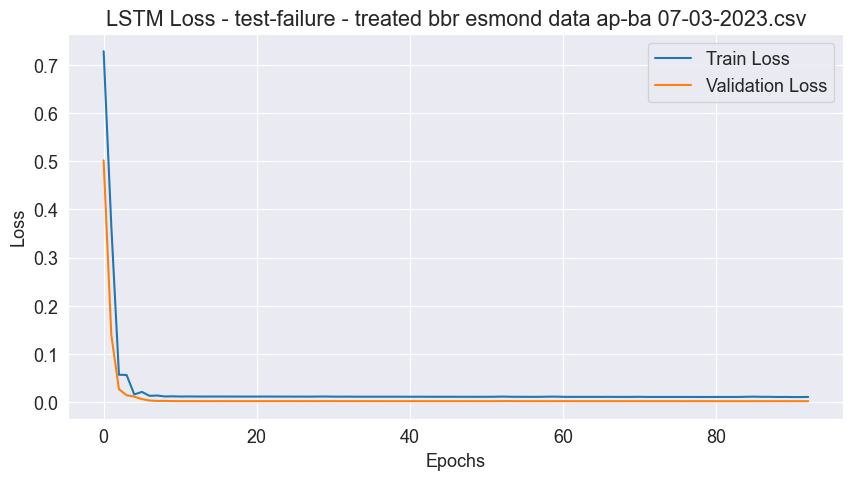

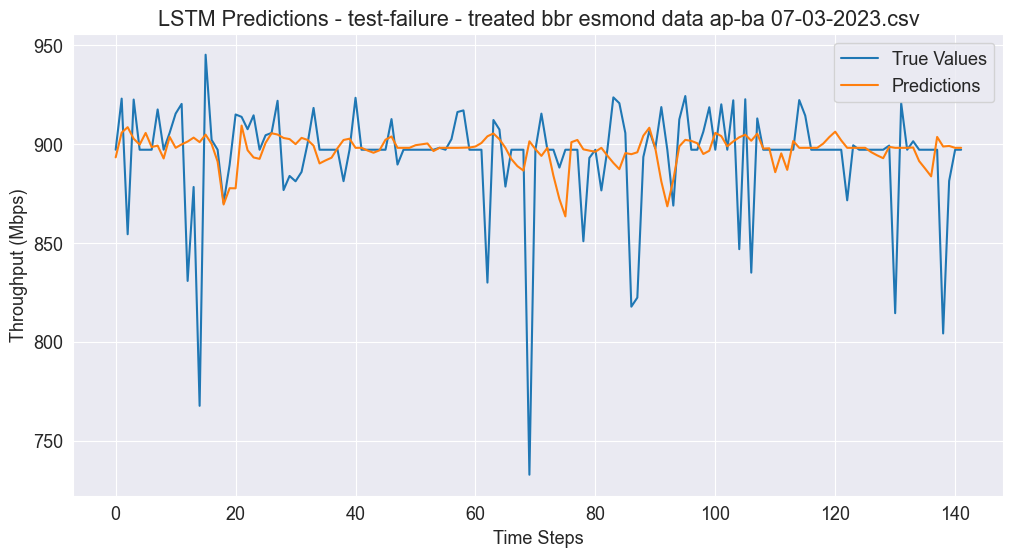

In [14]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping

# Certifique-se de importar funções auxiliares usadas no script
# from utils import bits_para_megabits, linear_interpolation, create_dataset, grid_search_cv
# from utils import create_lstm, walk_forward_validation_hybrid, validate_missing_data_prediction
# from utils import save_model, calculate_mean_history

# Variáveis globais/configuradas
LOOK_BACK = 3
WINDOW_SIZE = 28  # Tamanho da janela de predição
# TRAINING_OUTPUT = 'training_output.txt'  # Ajuste conforme necessário
# THROUGHPUT_DATASETS = './datasets'  # Caminho correto
# MODEL = './saved_models'  # Caminho correto para salvar os modelos

# Funções de plot

def plot_loss(history, title):
    plt.figure(figsize=(10, 5))
    plt.plot(history['loss'], label='Train Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(title)
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()


def plot_predictions(y_true, y_pred, title):
    plt.figure(figsize=(12, 6))
    plt.plot(y_true, label='True Values')
    plt.plot(y_pred, label='Predictions')
    plt.title(title)
    plt.xlabel('Time Steps')
    plt.ylabel('Throughput (Mbps)')
    plt.legend()
    plt.show()

# Redirecionar saída padrão
orig_stdout = sys.stdout

with open(TRAINING_OUTPUT, 'w', encoding='utf-8') as f:
    sys.stdout = f

    diretorio_raiz = THROUGHPUT_DATASETS
    evaluation = {}

    for pasta_raiz, subpastas, arquivos in os.walk(diretorio_raiz):
        for arquivo in arquivos:
            if arquivo.endswith('.csv'):
                caminho_arquivo = os.path.join(pasta_raiz, arquivo)
                try:
                    partes = caminho_arquivo.split(os.sep)
                    if len(partes) >= 6:
                        substring_desejada = partes[4] + ' - ' + partes[5]
                    else:
                        substring_desejada = arquivo.replace('.csv', '')

                    # Carga dos dados
                    df = pd.read_csv(caminho_arquivo, index_col='Timestamp')

                    # Remover colunas desnecessárias, se houver
                    if '0' in df.columns:
                        df.drop('0', axis=1, inplace=True)

                    # Pré-processamento
                    bits_para_megabits(df, 'Throughput')

                    # Criar máscara ANTES de qualquer manipulação
                    mask_total = ~(df['Throughput'].isna() | (df['Throughput'] == -1))

                    # Split treino-teste
                    train_size = int(len(df.index) * 0.8)
                    train_data = df.iloc[:train_size].copy()
                    test_data = df.iloc[train_size:].copy()

                    # Interpolação APENAS no treino
                    train_data = linear_interpolation(train_data)

                    # Normalização
                    scaler = MinMaxScaler().fit(train_data[['Throughput']])
                    train_scaled = scaler.transform(train_data[['Throughput']])
                    test_scaled = scaler.transform(test_data[['Throughput']])

                    mask_test = mask_total.iloc[train_size:].values

                    # Treinamento do modelo
                    X_train, y_train = create_dataset(train_scaled, LOOK_BACK)

                    best_params = grid_search_cv(
                        create_lstm, 64, X_train, [1e-3],
                        y_train, [300], [64], [10], 'LSTM'
                    )

                    # Treinar modelo final
                    model = create_lstm(64, X_train, best_params['learning_rate'])
                    history = model.fit(
                        X_train, y_train,
                        epochs=best_params['epochs'],
                        batch_size=best_params['batch_size'],
                        validation_split=0.2,
                        callbacks=[EarlyStopping(
                            monitor='val_loss',
                            patience=best_params['patience'],
                            restore_best_weights=True
                        )]
                    )

                    # Predição walk-forward
                    predictions = walk_forward_validation_hybrid(
                        model, scaler, train_scaled, test_scaled,
                        mask_test, LOOK_BACK, WINDOW_SIZE
                    )

                    # Avaliação
                    min_len = min(len(predictions), len(test_scaled) - LOOK_BACK)
                    y_test_valid = test_scaled[LOOK_BACK:LOOK_BACK + min_len]
                    mask_eval = mask_test[LOOK_BACK:LOOK_BACK + min_len]

                    y_test_orig = scaler.inverse_transform(y_test_valid)
                    predictions_arr = np.array(predictions[:min_len]).reshape(-1, 1)

                    lstm_eval = validate_missing_data_prediction(
                        predictions_arr, y_test_orig, mask_eval, 'LSTM'
                    )

                    evaluation[f"{substring_desejada}, {lstm_eval[3]}"] = lstm_eval[:3]

                    print(f"RMSE para {substring_desejada}: {lstm_eval[1]:.4f}")

                    # Salvar e plotar
                    save_model(model, MODEL, substring_desejada, 'LSTM')
                    plot_loss(history.history, f'LSTM Loss - {substring_desejada}')
                    plot_predictions(y_test_orig, predictions_arr, f'LSTM Predictions - {substring_desejada}')

                except Exception as e:
                    print(f"Erro no arquivo {arquivo}: {str(e)}")

    # Restaurar stdout
    sys.stdout = orig_stdout
